In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras import layers
import cv2

In [2]:
#!pip install gdown

In [3]:
#!gdown --id 1H3hZ2n6ZYLur4eOE3-4GCnG8wfzMP7-6 --output esun.tar
#!gdown --id 1fk2l4mgtpleNb1Zbgl4jqnzayVzJC7FD --output 'training data dic.txt'

In [4]:
#!rm -rf train
#!tar xvf esun.tar > /dev/null
#!tar xvf esun_less.tar > /dev/null
#!mv esun_less train

In [5]:
!ls -al train | head

total 207308
drwxrwxrwx 2 bu10 bu10 1826816  六   3 22:28 .
drwxrwxr-x 5 bu10 bu10    4096  六   4 17:47 ..
-rw-rw-rw- 1 bu10 bu10    1119  三  15 18:05 0_戶.jpg
-rw-rw-rw- 1 bu10 bu10    1873  三  15 18:00 10000_灣.jpg
-rw-rw-rw- 1 bu10 bu10    1519  三  15 17:40 10001_普.jpg
-rw-rw-rw- 1 bu10 bu10    2047  三  15 17:35 10003_琪.jpg
-rw-rw-rw- 1 bu10 bu10    1281  三  15 17:39 10004_琇.jpg
-rw-rw-rw- 1 bu10 bu10    1597  三  15 18:03 10005_芝.jpg
-rw-rw-rw- 1 bu10 bu10    2517  三  15 17:46 10006_瑜.jpg
ls: write error: Broken pipe


## Save Index and Number of Dataset ##

In [6]:
ori_train_path = 'train/'
train_list = os.listdir(ori_train_path)

train_dict = []

for file in train_list:
    try:
      train_dict.append((file[-5], int(file[0:-6])))
    except Exception as e:
      print(file)
      pass
    
print(train_dict[0:10])

[('拉', 7294), ('翠', 56378), ('瑋', 1935), ('瓊', 26716), ('資', 65735), ('奕', 3040), ('事', 55550), ('蘭', 39908), ('輝', 33802), ('事', 66841)]


In [7]:
train_dict.sort(key=lambda x:x[1])
print(train_dict[0:10])

[('戶', 0), ('經', 1), ('惠', 2), ('葳', 3), ('份', 4), ('拓', 5), ('萱', 6), ('義', 7), ('范', 9), ('簡', 10)]


In [8]:
labels = []
index = []
for i in range(len(train_dict)):
    labels.append(train_dict[i][0])
    index.append(train_dict[i][1])
    
    
print(labels[0:5])
print(index[0:5])

['戶', '經', '惠', '葳', '份']
[0, 1, 2, 3, 4]


In [9]:
dict = {'label':labels, 'index':index}
df = pd.DataFrame(dict)
df.to_csv('train_label_clean.csv', encoding='utf_8_sig')

# Text foucs

In [10]:
def count_area_pixel(img, start_pixel, img_high):
    pixel_cnt = 0
    for i in range(start_pixel, start_pixel + 64):
        for j in range(img_high):
            if img[j][i] == 0:
                pixel_cnt += 1
    return pixel_cnt


def search_text_position(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    H, W = thresh.shape
    max_pixel_area = 0
    max_pixel_pos = 0

    for i in range(W - 64):
        tmp = count_area_pixel(thresh, i, H)
        if tmp >= max_pixel_area:
            max_pixel_area = tmp
            max_pixel_pos = i

    img = img[0:H, max_pixel_pos:max_pixel_pos + 64]

    c_H, c_W, channel = img.shape

    #divide picture into 7 blocks by horizontal, try to find the line on the top and bottom by marking it as white line
    #7 is a changable parameter
    top = round(c_H / 7)
    bot = round(c_H / 7 * 6)
    img_top = img[0:top, 0:c_W]
    img_bot = img[bot:c_H, 0:c_W]
    is_line_threshold = 10
    minLineLength = 20
    maxLineGap = 10

    edges = cv2.Canny(img_top, 50, 250)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, is_line_threshold, minLineLength, maxLineGap)

    try:
        lines = lines[:, 0, :]
        #print(len(lines))
        for x1, y1, x2, y2 in lines:
            #3 is the height of white line 
            cv2.line(img_top, (x1, y1), (x2, y2), (255, 255, 255), 3)
    except Exception as e:
        #print("This top img didn't detect any line")
        e = e

    edges = cv2.Canny(img_bot, 50, 250)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, is_line_threshold, minLineLength, maxLineGap)

    try:
        lines = lines[:, 0, :]
        #print(len(lines))
        for x1, y1, x2, y2 in lines:
            #3 is the height of white line 
            cv2.line(img_bot, (x1, y1), (x2, y2), (255, 255, 255), 3) 
    except Exception as e:
        #print("This bottom img didn't detect any line")
        e = e

    return img

# Data augmentation

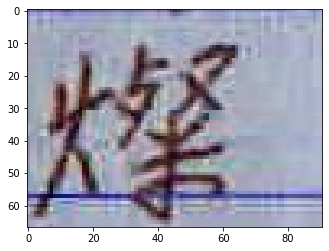

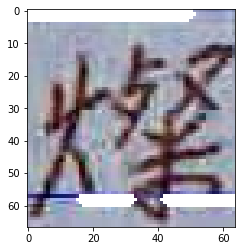

In [11]:
image = cv2.imread('train/55_燦.jpg')
plt.imshow(image)
plt.show()
image = search_text_position(image)
plt.imshow(image)
plt.show()

In [12]:
data_augmentation = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  #training will do normalization, so don't do it here
  #layers.experimental.preprocessing.Rescaling(1./255). 
])

In [13]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

Min and max pixel values: 0 255
Min and max pixel values: 3 255
Min and max pixel values: 2 255
Min and max pixel values: 4 255
Min and max pixel values: 2 255
Min and max pixel values: 0 255
Min and max pixel values: 3 255
Min and max pixel values: 3 255
Min and max pixel values: 1 255


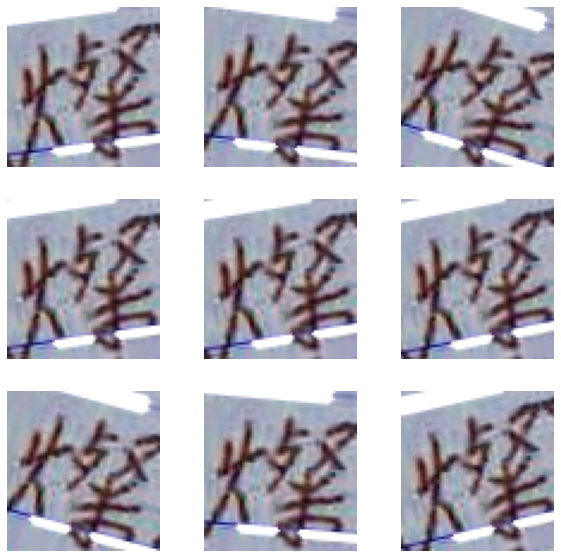

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  print("Min and max pixel values:", augmented_image.numpy().min(), augmented_image.numpy().max())

## Rename File to Load ##

In [15]:
#!rm -rf train_rename
#!mv train train_rename
#!ls -al train_rename | head

In [16]:
#new_train_path = 'train/'
#train_list = os.listdir(new_train_path)

#for file in train_list:
#    new_file_name = file.split('jpg')[0] + 'jpeg'
#    os.rename(new_train_path+file, new_train_path+new_file_name)

In [17]:
#!ls -al train_rename | head -n 10

## Load File, Encode the Label and Save to TFRecord ##

In [18]:
import tensorflow as tf 
import numpy as np
import glob
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [19]:
df = pd.read_csv('train_label_clean.csv', encoding='utf_8_sig')
print(df[0:5])

   Unnamed: 0 label  index
0           0     戶      0
1           1     經      1
2           2     惠      2
3           3     葳      3
4           4     份      4


### Label Encode to training data dic

In [20]:
f = open('training data dic.txt', encoding='utf_8_sig')
words = f.read().splitlines()
print(words[0:5])

['宋', '名', '楊', '活', '杜']


In [21]:
df['label_idx'] = None
print(df[0:5])

   Unnamed: 0 label  index label_idx
0           0     戶      0      None
1           1     經      1      None
2           2     惠      2      None
3           3     葳      3      None
4           4     份      4      None


In [22]:
for i in range(len(df['label'])):
    word = df['label'][i]
    if not word in words:
        #if this word is not listed in training data dic.txt, set to -1
        df['label_idx'][i] = -1
    else:
        idx = words.index(word)
        df['label_idx'][i] = idx


/home/bu10/anaconda3/envs/tbrain/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bu10/anaconda3/envs/tbrain/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
print(df[0:10])

   Unnamed: 0 label  index label_idx
0           0     戶      0       204
1           1     經      1        71
2           2     惠      2       604
3           3     葳      3        32
4           4     份      4       291
5           5     拓      5       313
6           6     萱      6       257
7           7     義      7       180
8           8     范      9       432
9           9     簡     10       628


In [24]:
print(min(df['label_idx']))
print(max(df['label_idx']))

-1
799


### Resize Image, Label and Save to TFRecord
Save label_encoded label into TFRecord.

In [12]:
width_re, height_re = 64, 64

In [26]:
import os
import tensorflow as tf
import tensorflow as tf 
import numpy as np
import glob
import cv2
from PIL import Image

In [27]:
data_path = 'train/'

images = glob.glob(data_path + '*.jpg')

tfrecord_filename = 'train_data_clean'+ str(width_re) + '_' + str(height_re) +'.tfrecords'
writer = tf.compat.v1.python_io.TFRecordWriter(tfrecord_filename)

In [28]:
print(images[0:5])

['train/7294_拉.jpg', 'train/56378_翠.jpg', 'train/1935_瑋.jpg', 'train/26716_瓊.jpg', 'train/65735_資.jpg']


In [29]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# _bytes is used for string/char values

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
# Create a dictionary with features that may be relevant.
def image_decode(id, label, image_string):
    feature = {
        'id' : _int64_feature(id), 
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

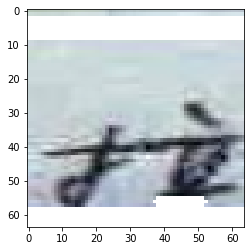

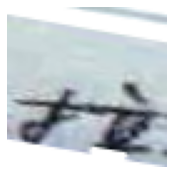

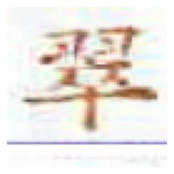

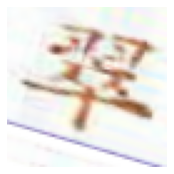

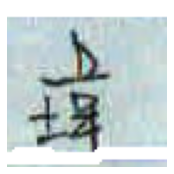

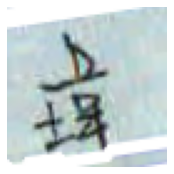

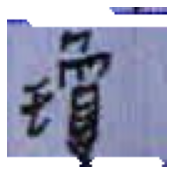

154026


In [30]:
img_count = 0

with tf.io.TFRecordWriter(tfrecord_filename) as writer:
  for image in images:
    img = cv2.imread(image)

    #resize
    img_re = cv2.resize(img, (width_re, height_re))
    #focus on text
    img_re = search_text_position(img_re)

    if (img_count < 10):
      plt.imshow(img_re)
      plt.show()

    id = int(image.split('/')[-1].split('_')[0])
    mask = df['index'] == id
    label = df[mask]['label_idx']
    label = label.iloc[0]
    
    #skip this image its label is not listed in training data dic.txt
    if label == -1:
        continue

    image_string = cv2.imencode('.jpg', img_re)[1].tobytes()
    tf_decode = image_decode(id, label, image_string)
    writer.write(tf_decode.SerializeToString())
    img_count+=1

    #data augumentation, pictures total to 206412
    img_re_aug = tf.expand_dims(img_re, 0)

    for i in range(2):
      augmented_image = data_augmentation(img_re_aug)
      image_string = cv2.imencode('.jpg', augmented_image[0].numpy())[1].tobytes()

      if (img_count < 10):
        plt.figure(figsize=(10, 10))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.axis("off")

      tf_decode = image_decode(id, label, image_string)
      writer.write(tf_decode.SerializeToString())
      img_count+=1


#expect 68804 pictures for ori 
print(img_count)

### Load Data from TFRecord

In [7]:
import tensorflow as tf 
import glob

In [11]:
raw_dataset = tf.data.TFRecordDataset('train_data_clean'+ str(width_re) + '_' + str(height_re) +'.tfrecords')
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)  

NameError: name 'width_re' is not defined

In [9]:
parsed_image_dataset

<MapDataset shapes: {image_raw: (), label: ()}, types: {image_raw: tf.string, label: tf.int64}>

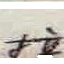

tf.Tensor(565, shape=(), dtype=int64)


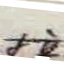

tf.Tensor(565, shape=(), dtype=int64)


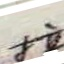

tf.Tensor(565, shape=(), dtype=int64)


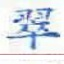

tf.Tensor(381, shape=(), dtype=int64)


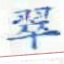

tf.Tensor(381, shape=(), dtype=int64)


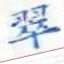

tf.Tensor(381, shape=(), dtype=int64)


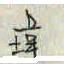

tf.Tensor(72, shape=(), dtype=int64)


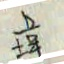

tf.Tensor(72, shape=(), dtype=int64)


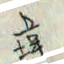

tf.Tensor(72, shape=(), dtype=int64)


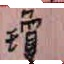

tf.Tensor(562, shape=(), dtype=int64)


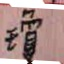

tf.Tensor(562, shape=(), dtype=int64)


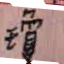

tf.Tensor(562, shape=(), dtype=int64)


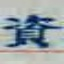

tf.Tensor(674, shape=(), dtype=int64)


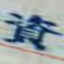

tf.Tensor(674, shape=(), dtype=int64)


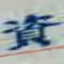

tf.Tensor(674, shape=(), dtype=int64)


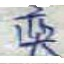

tf.Tensor(158, shape=(), dtype=int64)


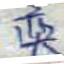

tf.Tensor(158, shape=(), dtype=int64)


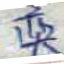

tf.Tensor(158, shape=(), dtype=int64)


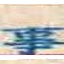

tf.Tensor(149, shape=(), dtype=int64)


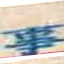

tf.Tensor(149, shape=(), dtype=int64)


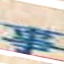

tf.Tensor(149, shape=(), dtype=int64)


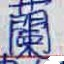

tf.Tensor(475, shape=(), dtype=int64)


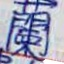

tf.Tensor(475, shape=(), dtype=int64)


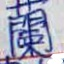

tf.Tensor(475, shape=(), dtype=int64)


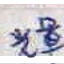

tf.Tensor(506, shape=(), dtype=int64)


In [10]:
import IPython.display as display
i = 0
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    print(image_features['label'])
    i += 1
    if i == 25:
        break

In [35]:
!ls -al

total 417368
drwxrwxr-x 5 bu10 bu10      4096  六   4 17:41 .
drwxrwxr-x 4 bu10 bu10      4096  五  30 10:26 ..
-rw-rw-r-- 1 bu10 bu10      2056  六   2 17:54 choose_800.py
-rw-rw-r-- 1 bu10 bu10      8642  五  30 11:06 CNN.py
drwxrwxr-x 4 bu10 bu10      4096  五  30 10:26 datasets
-rw-rw-r-- 1 bu10 bu10      6971  五  30 11:04 DenseNet_gray_3.py
-rw-rw-r-- 1 bu10 bu10      7018  六   2 17:57 EfficientNet_gray_3.py
-rw-rw-r-- 1 bu10 bu10      7071  五  30 10:30 GoogleNet_gray_3.py
drwxrwxr-x 2 bu10 bu10      4096  六   4 14:55 .ipynb_checkpoints
-rw-rw-r-- 1 bu10 bu10     22652  五  30 10:26 ocr_biLSTM.py
-rw-rw-r-- 1 bu10 bu10    814755  六   4 17:41 preprocessing.ipynb
-rw-rw-r-- 1 bu10 bu10      8265  六   4 14:03 preprocessing.py
-rw-rw-r-- 1 bu10 bu10      2347  五  30 10:26 text_focus_preprocessing.py
drwxrwxrwx 2 bu10 bu10   1826816  六   3 22:28 train
-rw-rw-r-- 1 bu10 bu10 423802887  六   4 17:46 train_data_clean64_64.tfrecords
-rw-rw-r-- 1 bu10 bu10      3199  五  24 23:41 training data dic.